In [377]:
# Prep

## Imports
import numpy as np # mainly for np.array, but also np.zeros, etc
from numba import jitclass, njit # jitclass for the interpolant and njit for the g2egm improvement
from numba import float64 # for the fieldspec of the jitclass

## Barycentric interpolant
### Field spec to allow JIT compilation of entire class
FieldSpec = [
    ('InvDenominator', float64),
    ('dBC', float64),
    ('dCB', float64),
    ('dCA', float64),
    ('dAC', float64),
    ('Simplex', float64[:, :]),
    ('Values', float64[:]),
    ('Weights', float64[:])
]

### Define interpolant class.
@jitclass(FieldSpec)
class BarycentricInterpolant(object):
    """
    A callable barycentric interpolant to be used in the G2EGM
    re-interpolation step.
    """
    def __init__(self, Simplex, SimplexValues):
        # TODO
        ## - verify inputs dimensions as bounds aren't checked
        ## - unroll A, B, C in a better way so nX, mX, dXY are
        ##   arrays of coordinates and differences. The actual
        ##   implementation will require solution of a linear
        ##   system, so we will probably just have efficient
        ##   methods for 1D and 2D, and then fall back to a
        ##   linsolve for higher D.
        
        nA, mA = Simplex[0][0], Simplex[0][1]
        nB, mB = Simplex[1][0], Simplex[1][1]
        nC, mC = Simplex[2][0], Simplex[2][1]
        self.Simplex = Simplex
        self.InvDenominator = self.BarycentricInverseDenominator()
        self.dBC = nB - nC
        self.dCB = mC - mB
        self.dCA = nC - nA
        self.dAC = mA - mC
        self.Values = SimplexValues
        self.Weights = np.zeros(len(self.Simplex[0]))
        
    def BarycentricInverseDenominator(self):
        """
        Calculates the inverse of the denominator for each barycentric
        weight associated with the simplex `self` represents.
        
        Parameters
        ----------
        None
        
        Returns
        -------
        None
        """
        # (nX,mX) are simply the two states in the "triangle"/R^2 case at vertex X
        ABC = self.Simplex
        nA, mA = ABC[0][0], ABC[0][1]
        nB, mB = ABC[1][0], ABC[1][1]
        nC, mC = ABC[2][0], ABC[2][1]

        # inverse of denominator for barycentric weights
        return 1.0/((nB - nC)*(mA - mC) + (mC - mB)*(nA - nC))

    
    def UpdateWeights(self, x):
        """
        Calculates the barycentric weight at `x` associated with the simplex
        `self` represents.
        
        Parameters
        ----------
        x : [np.array]
            The point in the common grid to re-interpolate down to.
        
        Returns
        -------
        None
        """        # (nX,mX) are simply the two states in the "triangle"/R^2 case at vertex X
        ABC = self.Simplex
        nA, mA = ABC[0][0], ABC[0][1]
        nB, mB = ABC[1][0], ABC[1][1]
        nC, mC = ABC[2][0], ABC[2][1]

        # (n,m) is the common grid point in R^2
        n, m = x[0], x[1]

        wA = (self.dBC*(m - mC) + self.dCB*(n - nC))*self.InvDenominator
        wB = (self.dCA*(m - mC) + self.dAC*(n - nC))*self.InvDenominator

        # Is an array the best thing to do here? It makes 
        # JITting easy, but it seems wasteful
        self.Weights = np.array([wA, wB, 1.0-wA-wB])
    
    # def __call__(self, x): # we cannot make this callable, due to
    # https://github.com/numba/numba/issues/1606
    def Interpolate(self, x, Update):
        """
        Interpolate `x` according to the simplex and values at simplex
        stored in `self`.
        
        Parameters
        ----------
        x : [np.array]
            The point in the common grid to re-interpolate down to.
        
        Returns
        -------
        None
        """
        if Update:
            self.UpdateWeights(x)
        
        # for some reason this won't work with np.inner! Maybe there's an asanyarray in there...
        return self.Weights[0]*self.Values[0]+self.Weights[1]*self.Values[1]+self.Weights[2]*self.Values[2]
        

Quick test, just to show that things compile and run.

In [378]:
ASimplex = np.array([[1.0,3.0],[3.,4.0],[1.5,3.0]])
print(ASimplex)
# Check the simplex interpolated values (should equal the second inputs)
bi = BarycentricInterpolant(ASimplex, np.array([1.0,2.0,3.0]))

[[1.  3. ]
 [3.  4. ]
 [1.5 3. ]]


Update weights (second positional argument True) and interpolate policy at [1.0, 3.0]

In [379]:
bi.Interpolate(np.array([1.0,3.0]), True)

1.0

Verify that weights put all weight on first vertex.

In [380]:
bi.Weights

array([1., 0., 0.])

Interpolate at [3.0, 1.0] way outside of simplex

In [381]:
bi.Interpolate(np.array([3.0,1.0]), True)

23.0

In [382]:
bi.Weights

array([-9., -2., 12.])

# G2EGM
It's time to put it all together.

In [383]:
# The G2EGM re-interpolate / upper envelope step
#@njit
def ReinterpolateG2EGM(CommonGrid, S, C,    # variables from segment
                    Policy, ValueAtPolicy, # best candidates so far
                    ValueEvalutation, Cutoff = -0.25):
    """
    ReinterpolateG2EGM(CommonGrid)

    Simultaneously re-interpolate segment solutions down to
    a common grid `CommonGrid`, construct the upper envelope and save
    the candidate policies and values at post-decision states.

    Parameters
    ----------
        CommonGrid : collection of points in the common grid
        S : array of simpleces
        C : array of controls at simpleces
        Policy : candidate policies
        ValueAtPolicy : w at Policy
        ValueEvaluation : function that calculates the value of a policy and post-decision state
        
    Returns
    -------
        Policy : candidate policies
        ValueAtPolicy : w at Policy
    """
    i = 0
    for s in S:
        # lb, ub = bounding_box(𝕤, G) # find hypercube around simplex
        # we *could* generate the points directly from indeces here instead of just the (lb, ub)
        bi = BarycentricInterpolant(s, C[i])
        for ig in range(len(CommonGrid)): # loop over all points, this is not the only way, we could look for points first
            g = G[ig]
            bi.UpdateWeights(g)  # get weights
            if all(Weight > Cutoff for Weight in bi.Weights): # is a "black" point
                PolicyAtg = bi.Interpolate(g, False) # interpolate given weights and corner policies
                ValueAtg = ValueEvalutation(PolicyAtg, g)
                if ValueAtg >= ValueAtPolicy[ig]:
                    Policy[ig] = PolicyAtg
                    ValueAtPolicy[ig] = ValueAtg         
        i += 1

    return Policy, ValueAtPolicy

In [393]:
# Mock-up model with two segments, one continuous choices.
# If the choice lands on segment one, the value is simply
# the value of the first state, and of it's the second
# segment, it's the value of the second state. This should
# result in a diagonally increasing V shaped surface.
G = [(a,b) for a in np.linspace(0,2,10) for b in np.linspace(0,2,10)];
Policy = np.zeros(len(G))
ValueAtPolicy = np.ones(len(G))*(-np.inf)

S1 = (np.array([[0.0,0.0],[0.0,2.0],[2.0,0.0]]), np.array([[2.0,2.0],[2.0,0.0],[0.0,2.0]]))
C1 = (np.array([0.0,0.0,2.0]), np.array([2.0,2.0,0.0]))

S2 = (np.array([[0.0,0.0],[0.0,2.0],[2.0,0.0]]), np.array([[2.0,2.0],[2.0,0.0],[0.0,2.0]]))
C2 = (np.array([0.0,2.0,0.0]), np.array([2.0,0.0,2.0]))

def myvalue1(x, g):
    return x

def myvalue2(x, g):
    return x

In [394]:
ReinterpolateG2EGM(G, S1, C1, Policy, ValueAtPolicy, myvalue1);
ReinterpolateG2EGM(G, S2, C2, Policy, ValueAtPolicy, myvalue2);

In [395]:
G1 = [g[0] for g in G]

In [396]:
Policy

array([0.        , 0.22222222, 0.44444444, 0.66666667, 0.88888889,
       1.11111111, 1.33333333, 1.55555556, 1.77777778, 2.        ,
       0.22222222, 0.22222222, 0.44444444, 0.66666667, 0.88888889,
       1.11111111, 1.33333333, 1.55555556, 1.77777778, 2.        ,
       0.44444444, 0.44444444, 0.44444444, 0.66666667, 0.88888889,
       1.11111111, 1.33333333, 1.55555556, 1.77777778, 2.        ,
       0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.88888889,
       1.11111111, 1.33333333, 1.55555556, 1.77777778, 2.        ,
       0.88888889, 0.88888889, 0.88888889, 0.88888889, 0.88888889,
       1.11111111, 1.33333333, 1.55555556, 1.77777778, 2.        ,
       1.11111111, 1.11111111, 1.11111111, 1.11111111, 1.11111111,
       1.11111111, 1.33333333, 1.55555556, 1.77777778, 2.        ,
       1.33333333, 1.33333333, 1.33333333, 1.33333333, 1.33333333,
       1.33333333, 1.33333333, 1.55555556, 1.77777778, 2.        ,
       1.55555556, 1.55555556, 1.55555556, 1.55555556, 1.55555

In [397]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [398]:
G1 = [g[0] for g in G]
G2 = [g[1] for g in G]

In [399]:
G1 = np.array(G1)
G2 = np.array(G2)

In [400]:
G1 = np.reshape(G1,(10,10))
G2 = np.reshape(G2,(10,10))
Policy2D = np.reshape(Policy, (10,10))

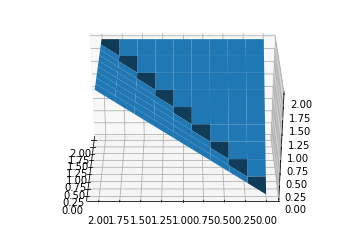

In [401]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(G1, G2, Policy2D)
ax.view_init(30, 180)